In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from lxml import etree
import numpy as np
import glob
from matplotlib.patches import Rectangle

In [2]:
print('Tensorflow version: {}'.format(tf.__version__))

Tensorflow version: 2.10.0


In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
gpus = tf.config.list_physical_devices(device_type='GPU')
cpus = tf.config.list_physical_devices(device_type='CPU')
print(gpus, cpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [6]:
img = tf.io.read_file('./mc/images/Abyssinian_1.jpg')

In [7]:
#解码图片
img = tf.image.decode_jpeg(img)

In [8]:
img.shape

TensorShape([400, 600, 3])

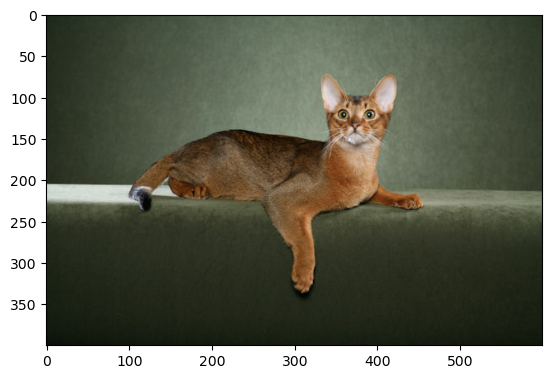

In [9]:
plt.imshow(img)

In [10]:
xml = open('./mc/annotations/xmls/Abyssinian_1.xml').read()

In [11]:
#建立选择器
sel = etree.HTML(xml)

In [12]:
width = int(sel.xpath('//size/width/text()')[0])
width

600

In [13]:
height = int(sel.xpath('//size/height/text()')[0])
xmin = int(sel.xpath('//bndbox/xmin/text()')[0])
xmax = int(sel.xpath('//bndbox/xmax/text()')[0])
ymin = int(sel.xpath('//bndbox/ymin/text()')[0])
ymax = int(sel.xpath('//bndbox/ymax/text()')[0])

In [14]:
width, height, xmin, xmax, ymin, ymax

(600, 400, 333, 425, 72, 158)

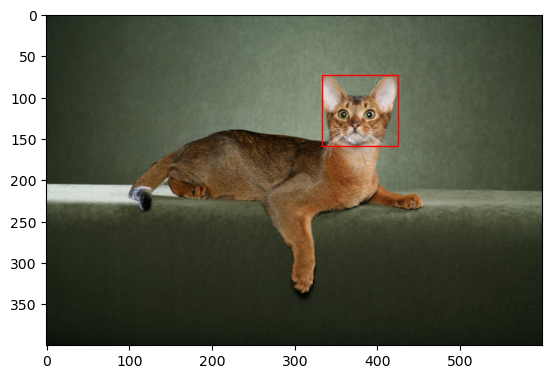

In [15]:
plt.imshow(img)
rect = Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),fill=False,color='red') #图片左下角的坐标值，宽度，高度，不填充，红色
ax = plt.gca()#获取当前图像
ax.axes.add_patch(rect)

In [16]:
#13.3

In [17]:
#图像缩放

In [18]:
img = tf.image.resize(img, [224,224])

In [19]:
#标准化 
img = img/255

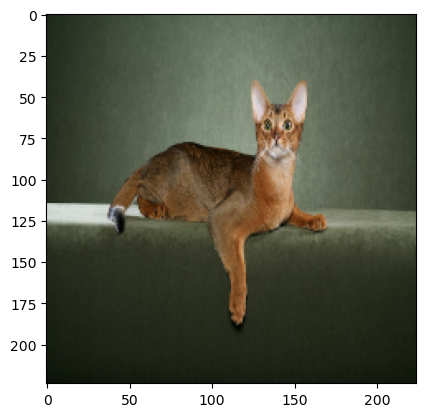

In [20]:
plt.imshow(img)

In [21]:
xmin = (xmin/width)*224
ymin = (ymin/height)*224
xmax = (xmax/width)*224
ymax = (ymax/height)*224

In [22]:
#创建输入管道

In [23]:
images = glob.glob('./mc/images/*.jpg')

In [24]:
images[:5]

['./mc/images\\Abyssinian_1.jpg',
 './mc/images\\Abyssinian_10.jpg',
 './mc/images\\Abyssinian_100.jpg',
 './mc/images\\Abyssinian_101.jpg',
 './mc/images\\Abyssinian_102.jpg']

In [25]:
len(images)

7390

In [26]:
xmls = glob.glob('./mc/annotations/xmls/*.xml')

In [27]:
xmls[:3]

['./mc/annotations/xmls\\Abyssinian_1.xml',
 './mc/annotations/xmls\\Abyssinian_10.xml',
 './mc/annotations/xmls\\Abyssinian_100.xml']

In [28]:
len(xmls) #这里并不是所有图片都有xml

3686

In [29]:
names = [x.split('\\')[-1].split('.xml')[0] for x in xmls]

In [30]:
names[:3]

['Abyssinian_1', 'Abyssinian_10', 'Abyssinian_100']

In [31]:
imgs_train = [img for img in images if (img.split('\\')[-1].split('.jpg')[0] in names)]
# 取出所有有xml的图片

In [32]:
len(imgs_train)

3686

In [33]:
imgs_test = [img for img in images if (img.split('\\')[-1].split('.jpg')[0] not in names)]
# 取出所有没有xml的图片

In [34]:
imgs_train.sort(key=lambda x:x.split('\\')[-1].split('.jpg')[0])
#对图片进行排序，使其与xml一一对应

In [35]:
xmls.sort(key=lambda x:x.split('\\')[-1].split('.xml')[0])
#对xml进行排序，使其与图片一一对应

In [36]:
imgs_train[-5:]

['./mc/images\\yorkshire_terrier_186.jpg',
 './mc/images\\yorkshire_terrier_187.jpg',
 './mc/images\\yorkshire_terrier_188.jpg',
 './mc/images\\yorkshire_terrier_189.jpg',
 './mc/images\\yorkshire_terrier_190.jpg']

In [37]:
xmls[-5:]

['./mc/annotations/xmls\\yorkshire_terrier_186.xml',
 './mc/annotations/xmls\\yorkshire_terrier_187.xml',
 './mc/annotations/xmls\\yorkshire_terrier_188.xml',
 './mc/annotations/xmls\\yorkshire_terrier_189.xml',
 './mc/annotations/xmls\\yorkshire_terrier_190.xml']

In [38]:
#13.5

In [39]:
def to_labels(path):
    xml = open('{}'.format(path)).read()
    sel = etree.HTML(xml)
    width = int(sel.xpath('//size/width/text()')[0])
    height = int(sel.xpath('//size/height/text()')[0])
    xmin = int(sel.xpath('//bndbox/xmin/text()')[0])
    xmax = int(sel.xpath('//bndbox/xmax/text()')[0])
    ymin = int(sel.xpath('//bndbox/ymin/text()')[0])
    ymax = int(sel.xpath('//bndbox/ymax/text()')[0])
    return [xmin/width, ymin/height, xmax/width, ymax/height]

In [40]:
labels = [to_labels(path) for path in xmls]

In [41]:
labels[:3]

[[0.555, 0.18, 0.7083333333333334, 0.395],
 [0.192, 0.21, 0.768, 0.582],
 [0.383248730964467, 0.142, 0.850253807106599, 0.534]]

In [42]:
out1, out2, out3, out4 = list(zip(*labels)) #zip(* ) 是zip的反操作

In [43]:
len(out1),len(out2),len(out3),len(out4)

(3686, 3686, 3686, 3686)

In [44]:
out1 = np.array(out1)
out2 = np.array(out2)
out3 = np.array(out3)
out4 = np.array(out4)

In [45]:
label_datasets = tf.data.Dataset.from_tensor_slices((out1, out2, out3, out4))

In [46]:
label_datasets

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))>

In [47]:
#图片数据

In [48]:
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)#图片解码
    img = tf.image.resize(img, [224, 224])
    img = img/127.5 - 1 #像素的范围是0到255，除255是0到1 乘2是0到2 减1是-1到1
    return img

In [49]:
image_dataset = tf.data.Dataset.from_tensor_slices(imgs_train)

In [50]:
image_dataset = image_dataset.map(load_image)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [51]:
image_dataset

<MapDataset element_spec=TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None)>

In [52]:
dataset = tf.data.Dataset.zip((image_dataset, label_datasets))

In [53]:
#自己练习：将数据集分成训练数据与测试数据

In [54]:
test_count = int(len(images)*0.2)#大约选取20%的数据作为测试数据
train_count = len(images) - test_count

#跳过测试数据的个数，得到训练数据
train_dataset = dataset.skip(test_count)
#取测试数据的个数
test_dataset = dataset.take(test_count) 

In [55]:
len(images)

7390

In [56]:
dataset

<ZipDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None)))>

In [57]:
train_dataset = train_dataset.repeat().shuffle(2208).batch(32)
test_dataset = test_dataset.repeat().batch(32)

In [58]:
#验证是否正确

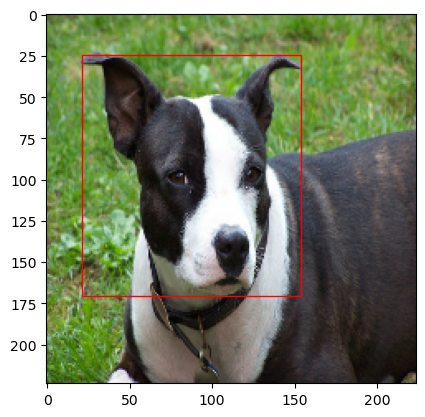

In [59]:
for img,label in train_dataset.take(1):
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0]))
    out1,out2,out3,out4 = label
    xmin,ymin,xmax,ymax = out1[0].numpy()*224,out2[0].numpy()*224,out3[0].numpy()*224,out4[0].numpy()*224
    rect = Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),fill=False,color='red') #图片左下角的坐标值，宽度，高度，不填充，红色
    ax = plt.gca()#获取当前图像
    ax.axes.add_patch(rect)
    plt.show()

In [60]:
#创建图像定位的模型

In [61]:
xception = tf.keras.applications.Xception(weights='imagenet',
                                         include_top=False,
                                         input_shape=(224,224,3))

In [62]:
inputs = tf.keras.layers.Input(shape=(224,224,3))

x = xception(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(2048, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)

out1 = tf.keras.layers.Dense(1)(x)
out2 = tf.keras.layers.Dense(1)(x)
out3 = tf.keras.layers.Dense(1)(x)
out4 = tf.keras.layers.Dense(1)(x)

prediction = [out1, out2, out3, out4]

model = tf.keras.models.Model(inputs=inputs, outputs=prediction)

In [63]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='mse',
              metrics=['mae']) #平均绝对误差

In [64]:
EPOCHS = 50
STEPS_PER_EPOCH = train_count//32
VALIDATION_STEPS = test_count//32

In [61]:
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_steps=VALIDATION_STEPS,
                    validation_data=test_dataset)

Train for 184 steps, validate for 46 steps
Epoch 1/50
  1/184 [..............................] - ETA: 1:46:29

ResourceExhaustedError:  OOM when allocating tensor with shape[728,728,1,1] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/xception/block5_sepconv1/separable_conv2d (defined at D:\soft\Anaconda\envs\python37\lib\site-packages\tensorflow_core\python\framework\ops.py:1751) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_19248]

Function call stack:
distributed_function


In [ ]:
#13.8

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

In [ ]:
model.save('detect_v1.h5')

In [65]:
new_model = tf.keras.models.load_model('detect_v1.h5')

In [66]:
#测试new_model的预测能力

1/1 [==============================] - 0s 40ms/step


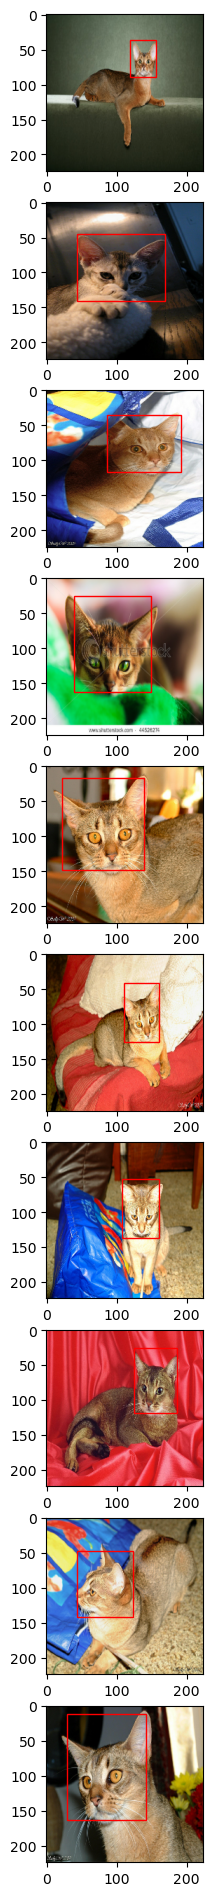

In [77]:
plt.figure(figsize=(8,24))#创建一个大的画布
for img,_ in test_dataset.take(1):#不需要label用占位符
    out1,out2,out3,out4 = new_model.predict(img)
    for i in range(10): #绘制三种图片
        plt.subplot(10, 1, i+1) #3行一列的图像，subplot是从1开始而不是从0开始，所以需要加1
        plt.imshow(tf.keras.preprocessing.image.array_to_img(img[i]))
        xmin, ymin, xmax, ymax = out1[i]*224,out2[i]*224,out3[i]*224,out4[i]*224
        rect = Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),fill=False,color='red') #图片左下角的坐标值，宽度，高度，不填充，红色
        ax = plt.gca()#获取当前图像
        ax.axes.add_patch(rect)